# Weather Temperature Prediction using ANN and Differential Evolution

This notebook demonstrates how to predict temperature using an Artificial Neural Network (ANN) whose hyperparameters are optimized using Differential Evolution.  
We use the ECTA 2023 dataset and visualize both model performance and a 24-hour forecast.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Loading and Preprocessing

In [2]:
df = pd.read_csv("ECTA 2023 Dataset.csv")

features = ['Relative Humidity', 'Wind Speed', 'Visibility', 'Pressure', 'Wind_Chill', 'Dewpoint Temp']
target = 'Temperature'

df = df.dropna()

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 3. Define the ANN Model

In [3]:
def build_ann(lr, neurons1, neurons2):
    model = keras.Sequential([
        keras.layers.Dense(neurons1, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(neurons2, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

## 4. Differential Evolution for Hyperparameter Optimization

In [4]:
# yperparameter bounds: [learning rate, neurons1, neurons2, batch_size]
HP_BOUNDS = [(0.0001, 0.1), (16, 128), (16, 128), (8, 64)]

eval_counter = 0

def evaluate(individual):
    global eval_counter
    eval_counter += 1
    lr, neurons1, neurons2, batch_size = individual
    neurons1, neurons2, batch_size = int(neurons1), int(neurons2), int(batch_size)
    print(f"\n[{eval_counter}] Evaluating: LR={lr:.5f}, Neurons1={neurons1}, Neurons2={neurons2}, Batch Size={batch_size}")

    model = build_ann(lr, neurons1, neurons2)
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=1)  # Set verbose=1 for progress

    loss, mae = model.evaluate(X_test, y_test, verbose=1)
    print(f"[{eval_counter}] MAE: {mae:.4f}")

    return mae

def differential_evolution_custom(evaluate_fn, bounds, popsize=5, mutation=0.5, crossover=0.7, generations=10):
    dim = len(bounds)
    lower_bounds = np.array([b[0] for b in bounds])
    upper_bounds = np.array([b[1] for b in bounds])
    population = np.random.rand(popsize, dim)
    population = lower_bounds + population * (upper_bounds - lower_bounds)
    fitness = np.array([evaluate_fn(ind) for ind in population])

    for gen in range(generations):
        print(f"\n=== Generation {gen+1}/{generations} ===")
        for i in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != i]
            a, b, c = population[np.random.choice(idxs, 3, replace=False)]
            mutant = a + mutation * (b - c)
            mutant = np.clip(mutant, lower_bounds, upper_bounds)
            cross_points = np.random.rand(dim) < crossover
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dim)] = True
            trial = np.where(cross_points, mutant, population[i])
            trial_fitness = evaluate_fn(trial)
            if trial_fitness < fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness
        print(f"Best MAE in generation {gen+1}: {fitness.min():.4f}")

    best_idx = np.argmin(fitness)
    return population[best_idx], fitness[best_idx]

## 5. Run Differential Evolution

In [5]:
best_hyperparams, best_mae = differential_evolution_custom(
    evaluate_fn=evaluate,
    bounds=HP_BOUNDS,
    popsize=5,
    generations=3,   # Increase for better results
    mutation=0.5,
    crossover=0.7
)

print(f"\nBest Hyperparameters: {best_hyperparams}")
print(f"Best MAE: {best_mae:.4f}")


[1] Evaluating: LR=0.03752, Neurons1=122, Neurons2=97, Batch Size=41
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2.3229 - mae: 0.5961
Epoch 2/10
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1006 - mae: 0.2081
Epoch 3/10
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0850 - mae: 0.2045
Epoch 4/10
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0445 - mae: 0.1523
Epoch 5/10
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0528 - mae: 0.1647
Epoch 6/10
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0584 - mae: 0.1699
Epoch 7/10
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0437 - mae: 0.1518
Epoch 8/10
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0437 - mae: 0.1477
Epoch 9/10
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 2s 980us/step - loss: 0.0269 - mae: 0.1195
Epoch 10/10
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0295 - mae: 0.1255  
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - loss: 0.0338 - mae: 0.1336
[1] MAE: 0.1335

[2] Evaluating: LR=0.01569, Neurons1=33, Neurons2=22, Batch Size=56
Epoch 1/10
1378/137

## 6. Train Final Model with Best Hyperparameters

In [6]:
best_lr, best_neurons1, best_neurons2, best_batch_size = best_hyperparams
final_model = build_ann(best_lr, int(best_neurons1), int(best_neurons2))
final_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=int(best_batch_size),
    validation_data=(X_test, y_test),
    verbose=1
)

#Evaluate final model
loss, mae = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Model Test MAE: {mae:.4f}")

Epoch 1/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 12.6200 - mae: 1.3205 - val_loss: 0.0299 - val_mae: 0.1143
Epoch 2/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0315 - mae: 0.1268 - val_loss: 0.0148 - val_mae: 0.0905
Epoch 3/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0218 - mae: 0.1114 - val_loss: 0.0155 - val_mae: 0.0926
Epoch 4/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0224 - mae: 0.1136 - val_loss: 0.0139 - val_mae: 0.0886
Epoch 5/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0198 - mae: 0.1069 - val_loss: 0.0200 - val_mae: 0.1108
Epoch 6/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0216 - mae: 0.1117 - val_loss: 0.0145 - val_mae: 0.0945
Epoch 7/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0184 - mae: 0.1034 - val_loss: 0.0128 - val_mae: 0.0879
Epoch 8/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0187 - mae: 0.1041 - val_loss: 0.0113 - val_mae: 0.0817
Epoch 9/50
1206/1206 ━━━━━━━━━━━━━━━━━━

## 7. Visualize Results

### Actual vs. Predicted Temperature (First 10 Test Samples)

603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


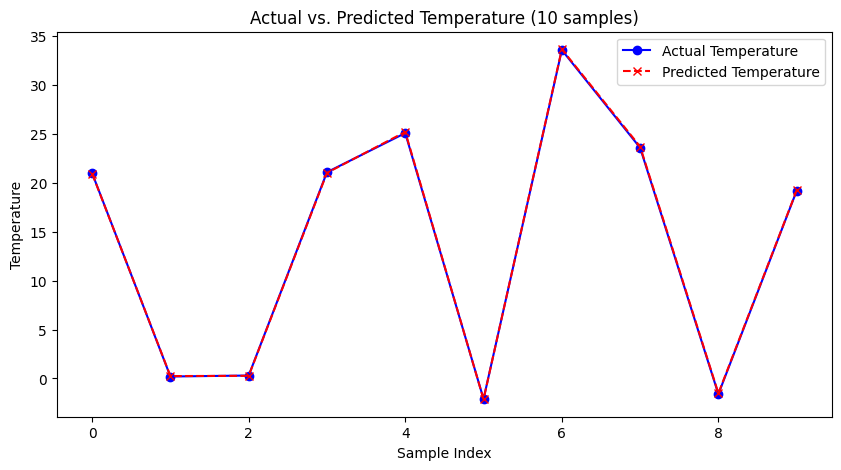

In [7]:
# Predictions on test data
y_pred = final_model.predict(X_test, verbose=1)

plt.figure(figsize=(10, 5))
plt.plot(y_test[:10], label='Actual Temperature', color='blue', marker='o')
plt.plot(y_pred[:10], label='Predicted Temperature', color='red', linestyle='dashed', marker='x')
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Temperature")
plt.title("Actual vs. Predicted Temperature (10 samples)")
plt.show()

### 24-Hour Temperature Forecast

For demonstration, we predict the next 24 hours by using the mean of test features as a placeholder for each hour.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


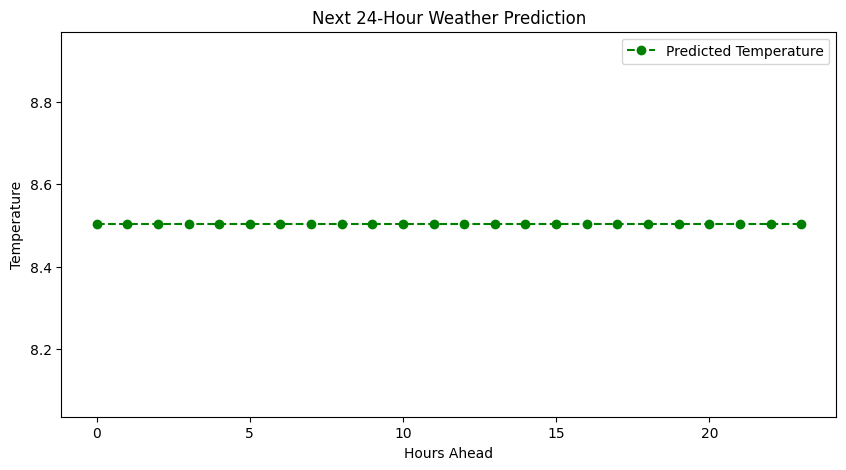

In [8]:
# Predict next 24 hours (using mean of test features for simplicity)
future_X = np.tile(np.mean(X_test, axis=0), (24, 1))
future_y_pred = final_model.predict(future_X, verbose=1)

plt.figure(figsize=(10, 5))
plt.plot(future_y_pred, marker='o', linestyle='dashed', color='green', label='Predicted Temperature')
plt.xlabel("Hours Ahead")
plt.ylabel("Temperature")
plt.title("Next 24-Hour Weather Prediction")
plt.legend()
plt.show()